# Generate simple numpy data from Devonshire Green weather station CSV

Will Furnass
2016-07-18

In [1]:
import pandas as pd
import numpy as np
import json
import os

In [2]:
# Read in raw csv data, skipping the first few rows (just metadata) and converting NA values
df = pd.read_csv('Devonshire_Green_meteorological_data-raw.csv.gz', skiprows=range(4), na_values=['No data'])

In [3]:
# Ignore 'status' columns as just metadata / units - store elsewhere
df_data_cols = [c for c in df.columns if 'Status' not in c]
df_data = df[df_data_cols].copy()

In [4]:
# Convert sensor data from objects to numpy numeric data type
df_data.iloc[:, 2:] = df_data.iloc[:, 2:].apply(pd.to_numeric)

In [5]:
# Drop the last row as contains duff data
df_data = df_data[df_data.Date != 'End']

In [6]:
# Split the 'Date' column into 'Year', 'Month' and 'Day' integer columns, stored in a new dataframe
date_parts = df_data.Date.str.split('-').apply(pd.Series).apply(pd.to_numeric)
date_parts.rename(columns={k: v for k, v in enumerate(('Year', 'Month', 'Day'))}, inplace=True)

# then merge this back into our main dataframe
df_data = pd.concat([df_data, date_parts], axis=1)

In [7]:
# Convert the 'Date' and 'Time' columns to numpy datetime and timedelta datatypes respectively
df_data['Time'] = pd.to_timedelta(df_data['Time'])
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Determine the 'Hour' of the day as a separate column using the 'Time' and 'Date' columns
df_data['Hour'] = (((df_data.Date + df_data.Time) - df_data.Date) \
                   .apply(lambda dt: dt.total_seconds()) / 3600) \
                   .astype(np.int)
    
# Replace all 'Hour' values of 24 with 0
df_data['Hour'] = df_data['Hour'].replace(24, 0)

# Drop the 'Date' and 'Time' columns as they are not needed any more
df_data.drop(['Date', 'Time'], axis=1, inplace=True, errors='ignore')

In [8]:
# Reorder columns so that 'Year', 'Month', 'Day' and 'Hour' come first:
df_col_names = list(df_data)
df_data = df_data[df_col_names[-4:] + df_col_names[:-4]]

In [9]:
# Shorten some column names
df_data.rename(columns={c: c.replace(' (Hourly measured)', '') for c in df_data.columns}, inplace=True)

In [10]:
df_data.head()

,Year,Month,Day,Hour,Ozone,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,PM10 particulate matter,Non-volatile PM10,Volatile PM10,PM2.5 particulate matter,Non-volatile PM2.5,Volatile PM2.5,Modelled Wind Direction,Modelled Wind Speed,Modelled Temperature
0,2015,1,1,1,38.84963,9.07037,29.62208,43.52978,33.2,27.3,5.9,25.7,21.1,4.6,227.7,6.8,6.1
1,2015,1,1,2,49.09422,1.59571,21.95741,24.40414,29.7,22.2,7.5,18.7,15.3,3.4,226.1,6.1,6.8
2,2015,1,1,3,48.09637,2.36207,17.91343,21.53523,18.3,17.4,0.9,14.9,10.8,4.1,232.5,7.1,7.8
3,2015,1,1,4,46.54970,3.74783,19.19194,24.93852,15.5,14.8,0.7,15.0,9.9,5.1,230.6,6.5,8.2
4,2015,1,1,5,51.98799,2.11012,13.29092,16.52639,9.2,8.8,0.4,11.5,8.1,3.4,226.2,6.8,8.5


In [11]:
# Load metadata
with open('Devonshire_Green_meteorological_metadata-preproc.json', 'r') as f:
    metadata = json.load(f)
metadata

[{'channels': [{'name': 'Ozone', 'units': 'ugm-3'},
   {'name': 'Nitric oxide', 'units': 'ugm-3'},
   {'name': 'Nitrogen dioxide', 'units': 'ugm-3'},
   {'name': 'Nitrogen oxides as nitrogen dioxide', 'units': 'ugm-3'},
   {'name': 'PM10 particulate matter', 'units': 'ugm-3'},
   {'name': 'Non-volatile PM10', 'units': 'ugm-3'},
   {'name': 'Volatile PM10', 'units': 'ugm-3'},
   {'name': 'PM2.5 particulate matter', 'units': 'ugm-3'},
   {'name': 'Non-volatile PM2.5', 'units': 'ugm-3'},
   {'name': 'Volatile PM2.5', 'units': 'ugm-3'},
   {'name': 'Modelled Wind Direction', 'units': 'deg'},
   {'name': 'Modelled Wind Speed', 'units': 'ms-1'},
   {'name': 'Modelled Temperature', 'units': 'degC'}],
  'downloaded from': 'https://uk-air.defra.gov.uk/data/data_selector',
  'station': 'Sheffield Devonshire Green',
  'time bracket': 'Hour ending',
  'timezone': 'GMT',
  'type': 'Hourly measurement data'}]

<IPython.core.display.Javascript object>


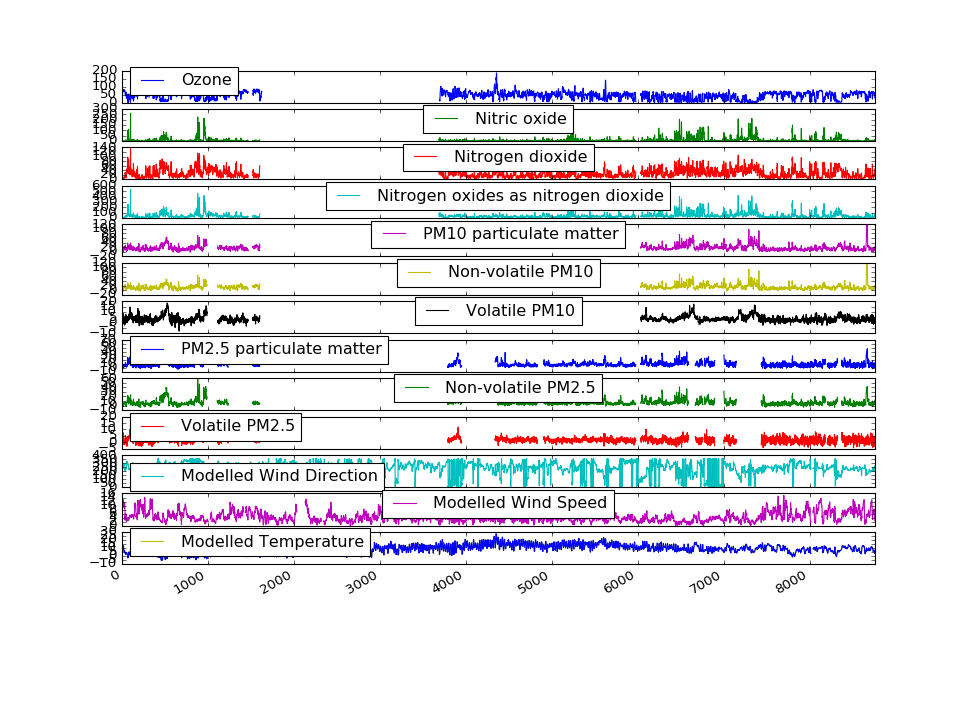

In [12]:
# Plot all data
import matplotlib.pyplot as plt
plt.close('all')
%matplotlib notebook
df_data.iloc[:, 4:].plot(subplots=True)
plt.show()

In [58]:
# Check that can get datetime64 array from date part columns
def date_parts_to_datetime64(year, month=0, day=0, hour=0):
    return np.array(['{:4>2.0f}-{:0>2.0f}-{:0>2.0f} {:0>2.0f}:00:00'.format(y, m, d, h) 
                     for (y, m, d, h) in np.broadcast(year, month, day, hour)],
                    dtype='datetime64')

df_col_names = list(df_data)
arr_2d = df_data.values

dt64s = date_parts_to_datetime64(*arr_2d[:, :4].T)
dt64s.shape, dt64s.dtype.name, dt64s.min(), dt64s.max()

((8760,),
 'datetime64[s]',
 numpy.datetime64('2015-01-01T00:00:00'),
 numpy.datetime64('2015-12-31T23:00:00'))

In [60]:
df_data.to_csv('Devonshire_Green_meteorological_data-preproc.csv', index=False)